In [2]:
from pandas import datetime
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [3]:
df = pd.read_csv('tute1.csv')

In [4]:
df.head()

,Unnamed: 0,Sales,AdBudget,GDP
0,Mar-81,1020.2,659.2,251.8
1,Jun-81,889.2,589.0,290.9
2,Sep-81,795.0,512.5,290.8
3,Dec-81,1003.9,614.1,292.4
4,Mar-82,1057.7,647.2,279.1


In [5]:
df["Month"] = list(map(lambda x: datetime.strptime(x, '%b-%y').strftime('%m-%Y'), df["Unnamed: 0"]))

In [6]:
df.head()

,Unnamed: 0,Sales,AdBudget,GDP,Month
0,Mar-81,1020.2,659.2,251.8,03-1981
1,Jun-81,889.2,589.0,290.9,06-1981
2,Sep-81,795.0,512.5,290.8,09-1981
3,Dec-81,1003.9,614.1,292.4,12-1981
4,Mar-82,1057.7,647.2,279.1,03-1982


In [7]:
sr = pd.to_datetime(df['Month'])
df['Time'] = pd.DataFrame(sr)
df.head()

,Unnamed: 0,Sales,AdBudget,GDP,Month,Time
0,Mar-81,1020.2,659.2,251.8,03-1981,1981-03-01
1,Jun-81,889.2,589.0,290.9,06-1981,1981-06-01
2,Sep-81,795.0,512.5,290.8,09-1981,1981-09-01
3,Dec-81,1003.9,614.1,292.4,12-1981,1981-12-01
4,Mar-82,1057.7,647.2,279.1,03-1982,1982-03-01


In [8]:
df = df.drop(['Unnamed: 0', 'AdBudget', 'GDP', 'Month'], axis = 1)

In [9]:
df.tail()

,Sales,Time
95,1018.7,2004-12-01
96,1112.5,2005-03-01
97,997.4,2005-06-01
98,826.8,2005-09-01
99,992.6,2005-12-01


In [10]:
df.shape

(100, 2)

### Data Preprocessing dan Visualisasi

**Langkah paling mendasar adalah kita menentukan index penelitian terlebih dahulu, pada kasus ini diambil "Time".**

In [11]:
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m')

In [12]:
y = df.set_index('Time')

In [13]:
y.index

DatetimeIndex(['1981-03-01', '1981-06-01', '1981-09-01', '1981-12-01', '1982-03-01', '1982-06-01', '1982-09-01', '1982-12-01', '1983-03-01', '1983-06-01', '1983-09-01', '1983-12-01', '1984-03-01', '1984-06-01', '1984-09-01', '1984-12-01', '1985-03-01', '1985-06-01', '1985-09-01', '1985-12-01', '1986-03-01', '1986-06-01', '1986-09-01', '1986-12-01', '1987-03-01', '1987-06-01', '1987-09-01', '1987-12-01', '1988-03-01', '1988-06-01', '1988-09-01', '1988-12-01', '1989-03-01', '1989-06-01', '1989-09-01', '1989-12-01', '1990-03-01', '1990-06-01', '1990-09-01', '1990-12-01', '1991-03-01', '1991-06-01', '1991-09-01', '1991-12-01', '1992-03-01', '1992-06-01', '1992-09-01', '1992-12-01', '1993-03-01', '1993-06-01', '1993-09-01', '1993-12-01', '1994-03-01', '1994-06-01', '1994-09-01', '1994-12-01', '1995-03-01', '1995-06-01', '1995-09-01', '1995-12-01', '1996-03-01', '1996-06-01', '1996-09-01', '1996-12-01', '1997-03-01', '1997-06-01', '1997-09-01', '1997-12-01', '1998-03-01', '1998-06-01',
     

In [14]:
y.isnull().sum()

Sales    0
dtype: int64

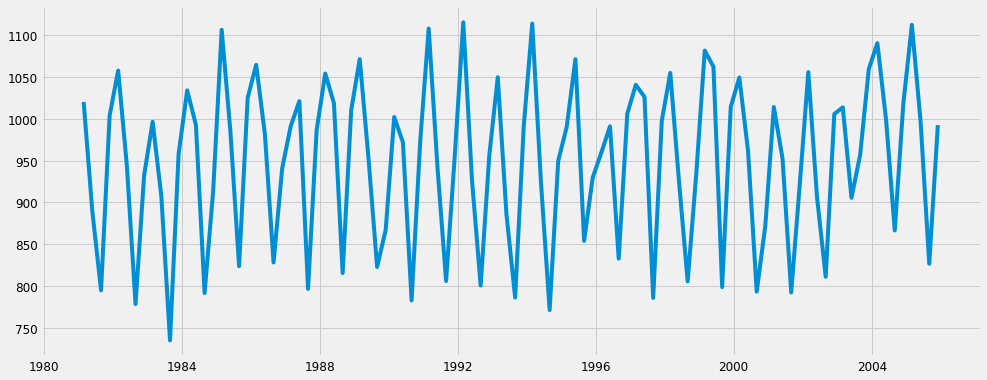

In [15]:
plt.figure(figsize=(15,6))
plt.plot(y)

Hasil plot dari densitas data kita dapat dianalisa untuk mendapatkan insight baru, seperti:

1. Distribusi pada dataset ternyata belum sempurna (distribusi normal/Gaussian).
2. Mungkin transformasi dapat kita lakukan dan berguna untuk pemodelan datanya.
3. Modelnya masih belum stasioner.

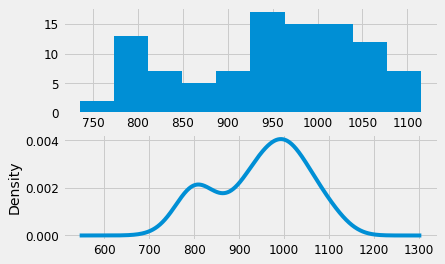

In [16]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.Sales.hist()
pyplot.subplot(212)
y.Sales.plot(kind='kde')
pyplot.show()

Box and Whisker Plots:

1. Median values across years confirms an upwards trend
2. Steady increase in the spread, or middle 50% of the data (boxes) over time
3. A model considering seasonality might work well

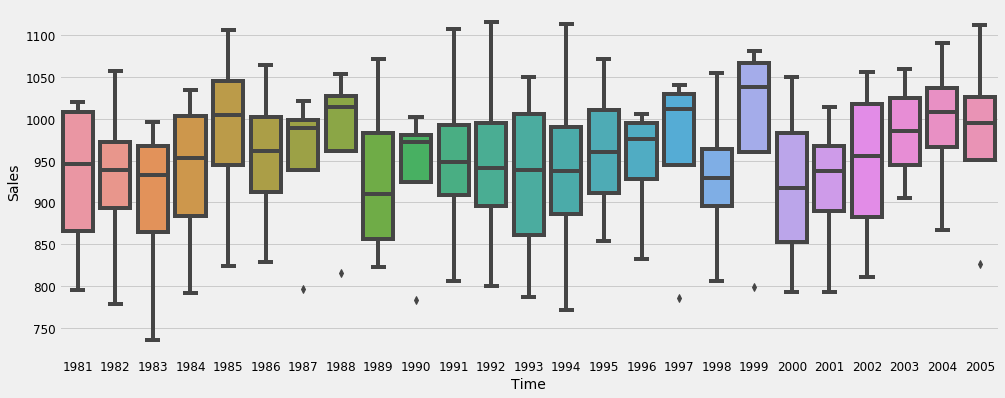

In [76]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.Sales.index.year, y.Sales, ax=ax)

Decomposing using statsmodel:

1. Untuk dekomposisi dataset timeseries kita bisa gunakan statmodels.
2. Dekomposisi time series adalah pembagian beberapa bagian pada time series dengan fungsi statistiknya yang masing-masing bagian mewakili suatu pola atau kategori.
3. Dengan penggunaan statsmodels, kita dapat melihat trend, seasonal, hingga plot residuan dari komponen setiap data kita.

In [78]:
pd.plotting.register_matplotlib_converters()

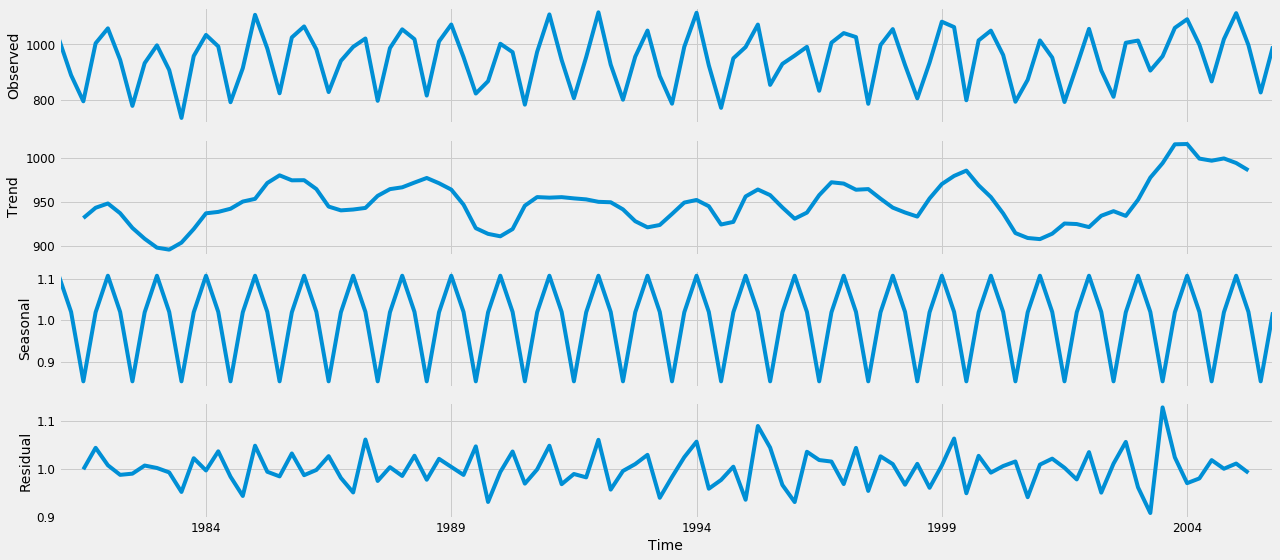

In [79]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
#matplotlib.rcParams['figure.figsize'] = 18, 8
plt.show()

### Stationarity

**Why?**
1. Dikatakan stasioner apabila nilai statisik dari model (mean dan variansi) konstan terhadap waktu.
2. Secara umum, time series yang mengikuti pola tertentu cenderung memiliki pola yang sama di masa depan.
3. Pengaplikasian teori stasioneritas time series lebih mudah digunakan.

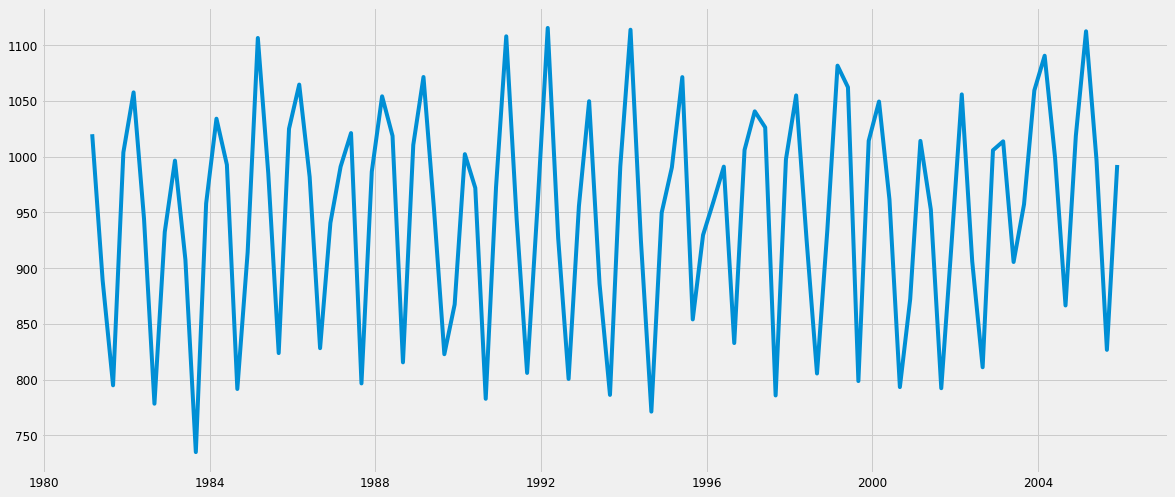

In [80]:
plt.plot(y)

**We can check stationarity using the following:**

1. **ACF and PACF plots**: If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
2. **Plotting Rolling Statistics**: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
3. **Augmented Dickey-Fuller Test**: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

### ACF and PACF

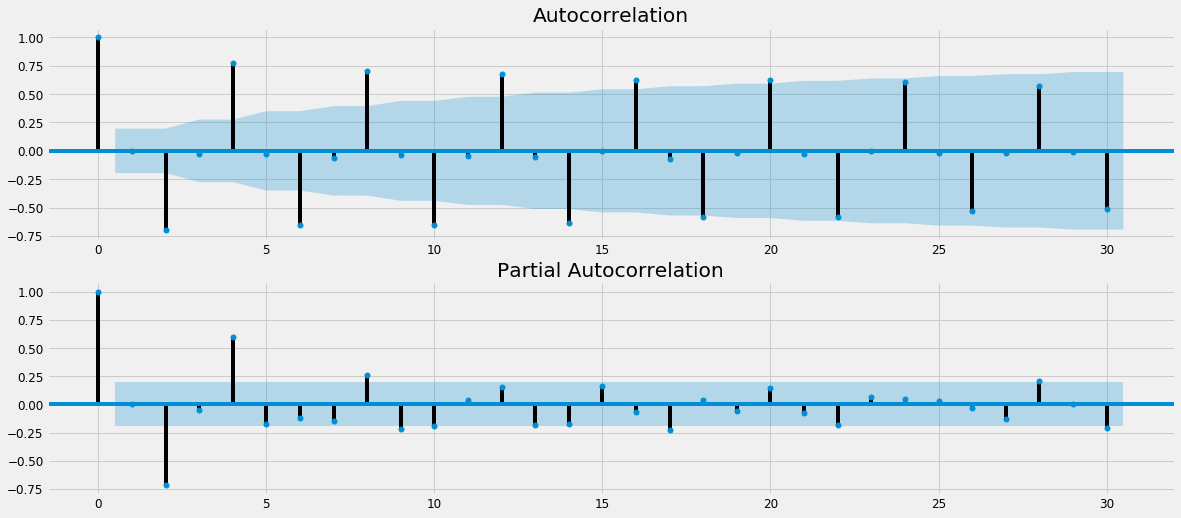

In [82]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(y.Sales, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.Sales, ax=pyplot.gca(), lags = 30)
pyplot.show()

### Plotting Rolling Statistics

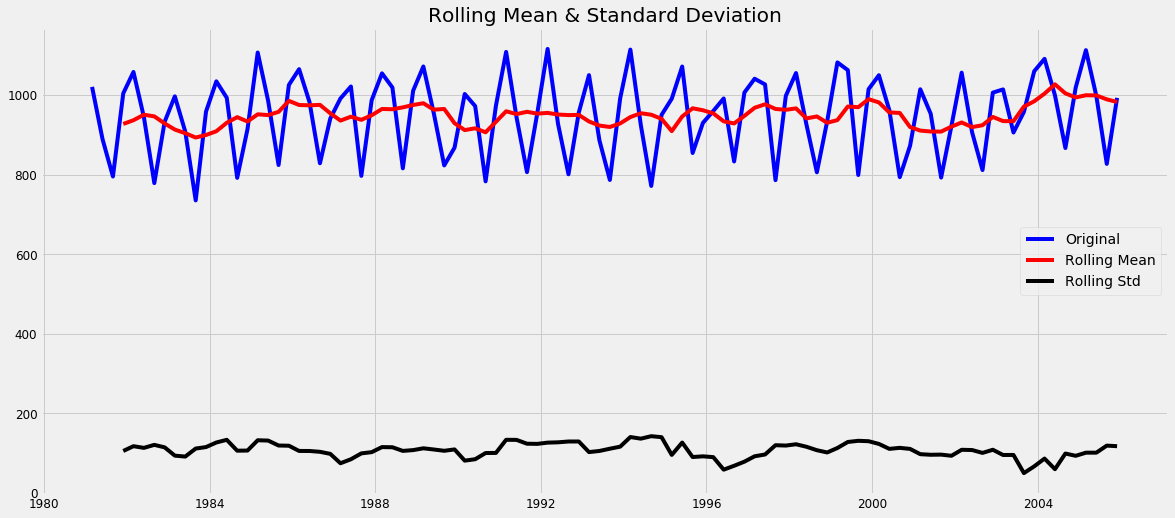

In [266]:
#Determing rolling statistics

#rolmean = pd.rolling_mean(y, window=12)
rolmean = y.rolling(4).mean()
#rolstd = pd.rolling_std(y, window=12)
rolstd = y.rolling(4).std()

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Augmented Dickey-Fuller Test

1. The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).
2. Null hypothesis: The time series is not stationary
3. Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

In [267]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.Sales, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -3.262755
p-value                         0.016628
#Lags Used                      9.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


In [268]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    moving_avg = ts_log.rolling(4).mean()
    
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

### Making Time Series Stationary
There are 2 major reasons behind non-stationarity of a time series:

1. **Trend** – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. **Seasonality** – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

**Transformations**
1. We can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

**Transformasi Log Dataset**

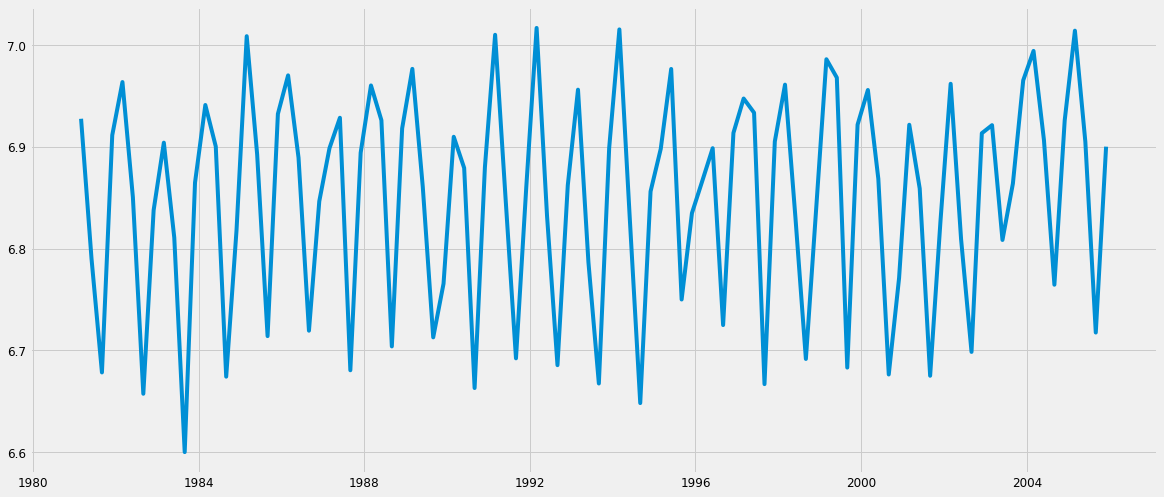

In [269]:
ts_log = np.log(y)
plt.plot(ts_log)

In [270]:
ts_log.head()

,Sales
Time,
1981-03-01,6.927754
1981-06-01,6.790322
1981-09-01,6.678342
1981-12-01,6.911648
1982-03-01,6.963852


In [271]:
y.head()

,Sales
Time,
1981-03-01,1020.2
1981-06-01,889.2
1981-09-01,795.0
1981-12-01,1003.9
1982-03-01,1057.7


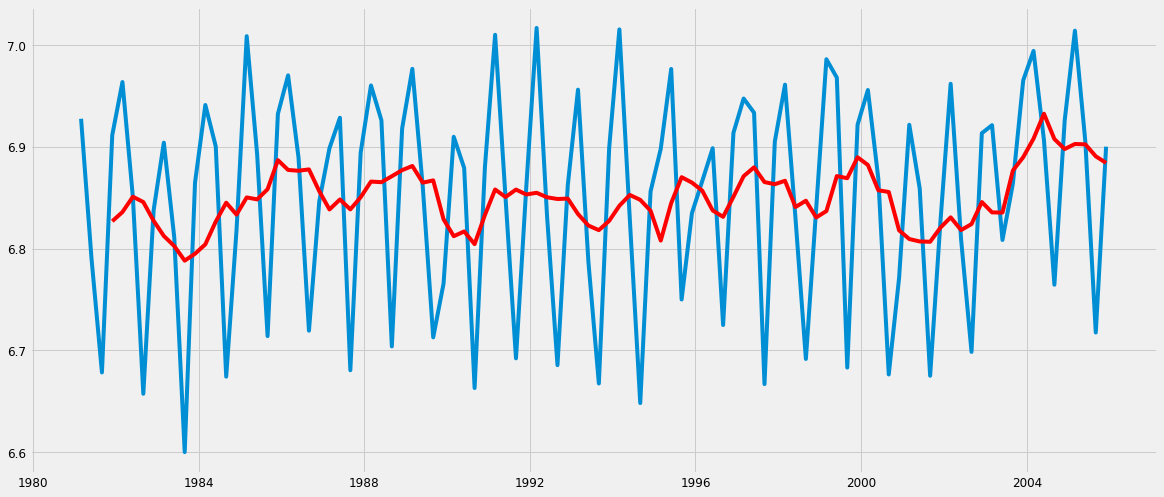

In [272]:
moving_avg = ts_log.rolling(4).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [273]:
ts_log_moving_avg_diff = ts_log.Sales - moving_avg.Sales
ts_log_moving_avg_diff.head(12)

Time
1981-03-01         NaN
1981-06-01         NaN
1981-09-01         NaN
1981-12-01    0.084631
1982-03-01    0.127811
1982-06-01   -0.000548
1982-09-01   -0.188486
1982-12-01    0.010459
1983-03-01    0.091740
1983-06-01    0.008314
1983-09-01   -0.188253
1983-12-01    0.069922
Name: Sales, dtype: float64

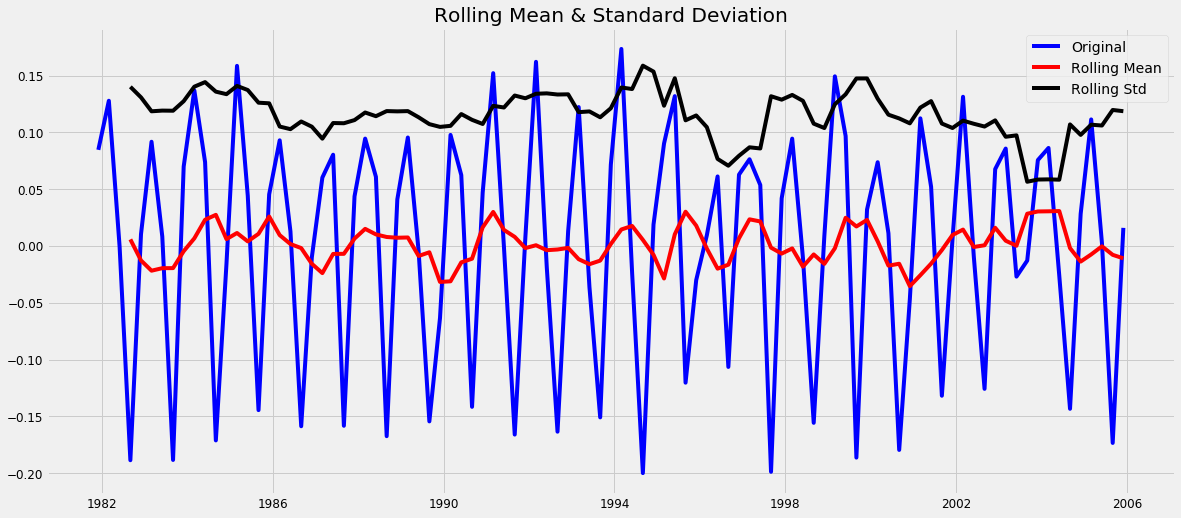

Results of Dickey-Fuller Test:
Test Statistic                 -4.747865
p-value                         0.000068
#Lags Used                      9.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64


In [274]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

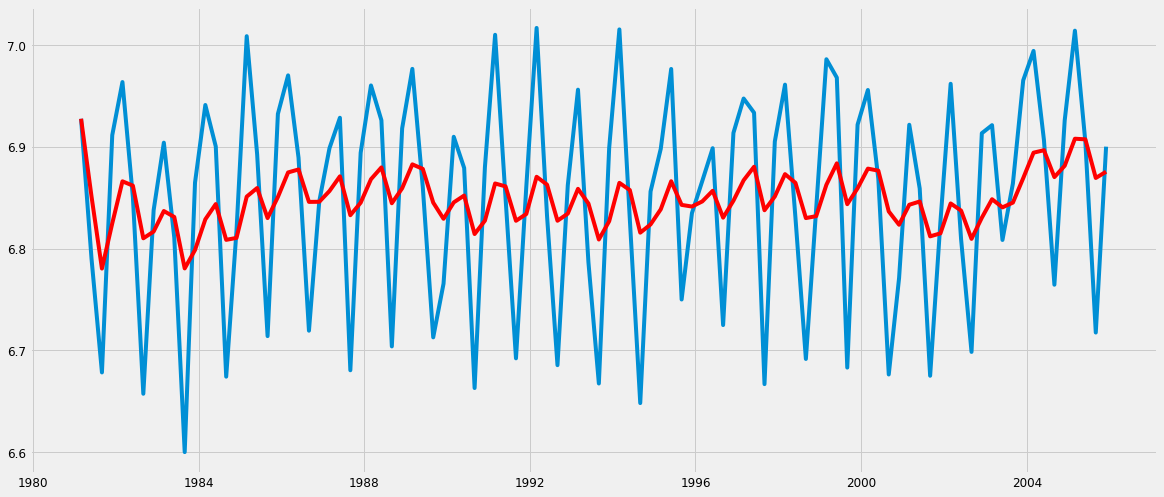

In [275]:
expwighted_avg = ts_log.ewm(4).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

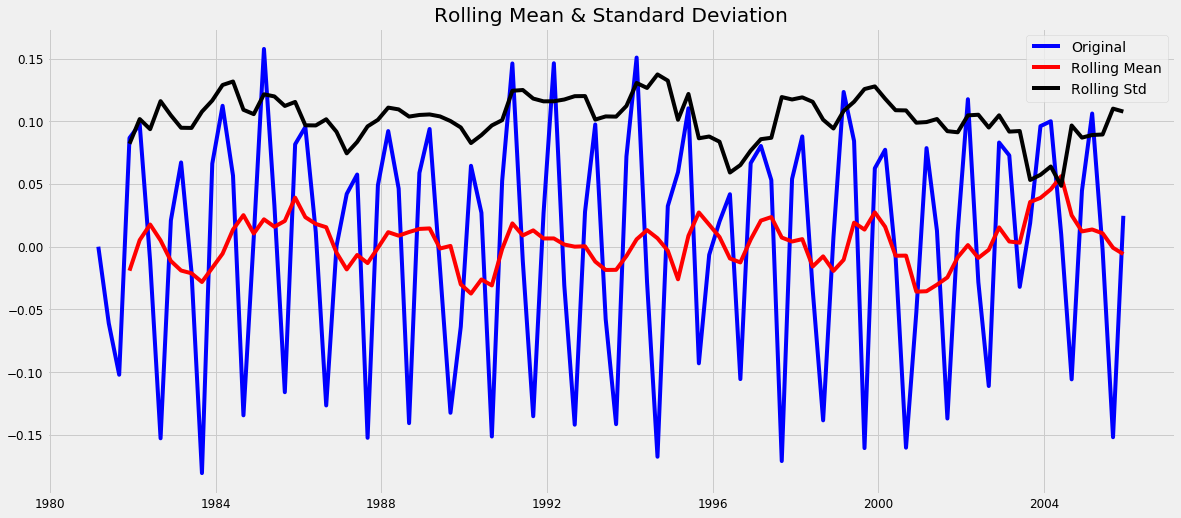

Results of Dickey-Fuller Test:
Test Statistic                 -3.802037
p-value                         0.002887
#Lags Used                      8.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64


In [276]:
ts_log_ewma_diff = ts_log.Sales - expwighted_avg.Sales
test_stationarity(ts_log_ewma_diff)

**Differencing**

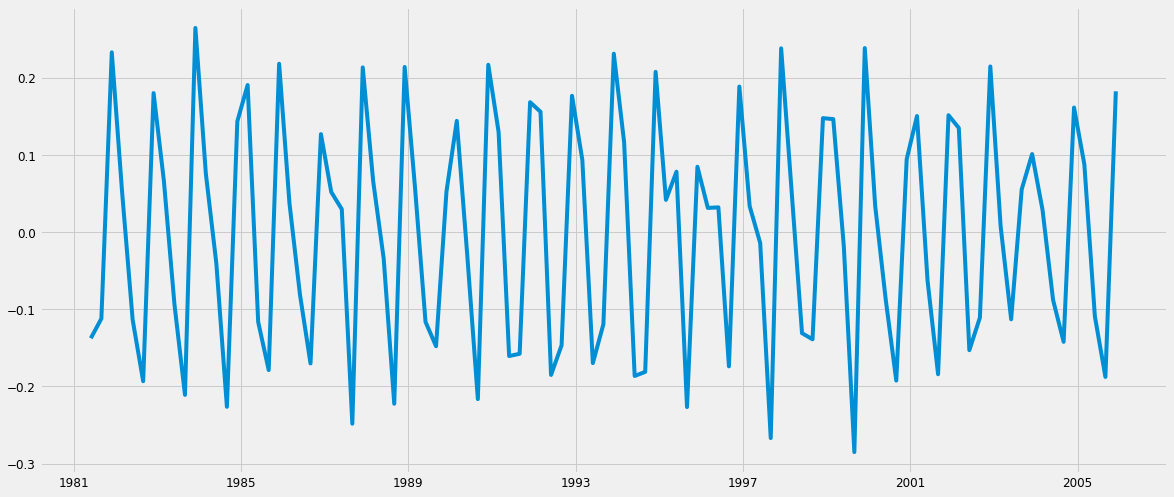

In [278]:
ts_log_diff = ts_log.Sales - ts_log.Sales.shift()
plt.plot(ts_log_diff)

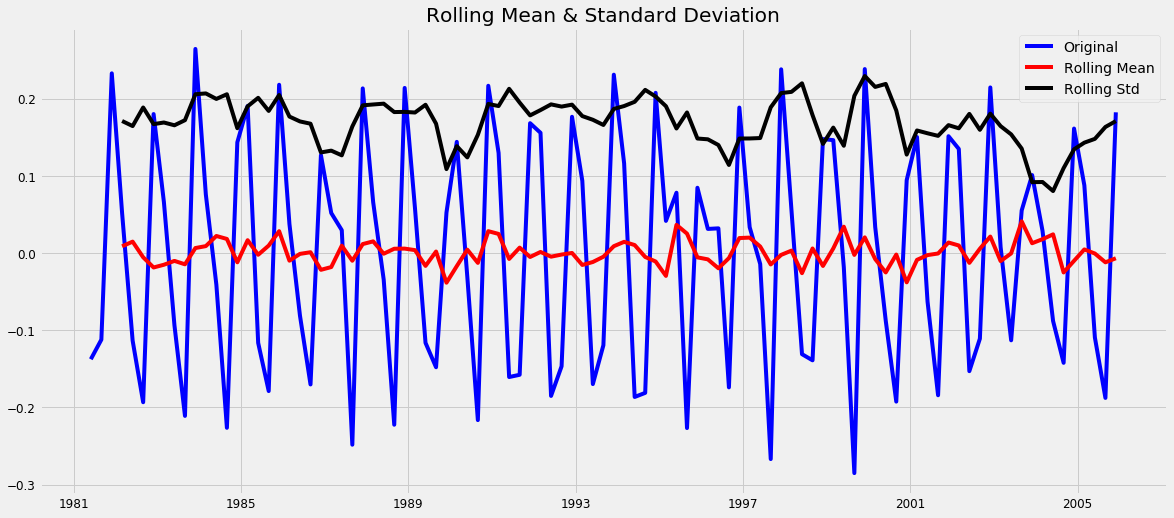

Results of Dickey-Fuller Test:
Test Statistic                 -5.098185
p-value                         0.000014
#Lags Used                     10.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


In [279]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

**Decomposition**

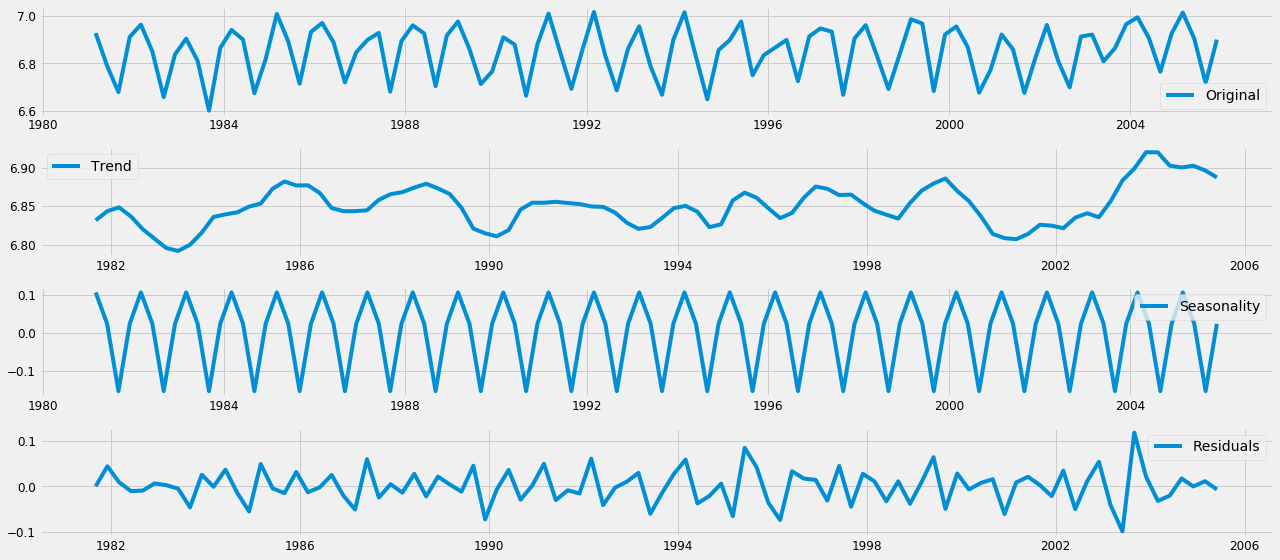

In [280]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

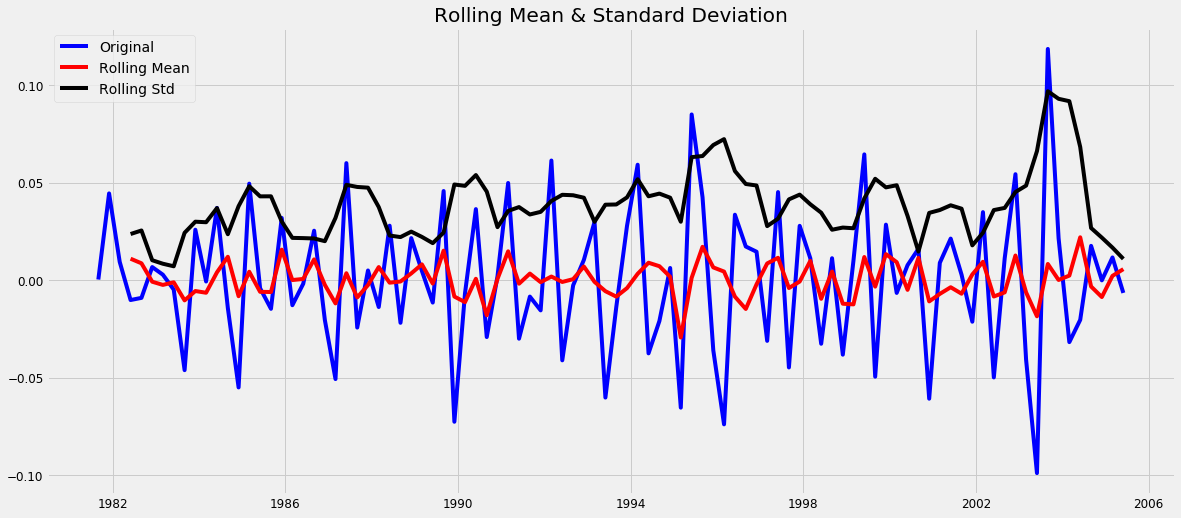

Results of Dickey-Fuller Test:
Test Statistic                -6.204835e+00
p-value                        5.690975e-08
#Lags Used                     8.000000e+00
Number of Observations Used    8.700000e+01
Critical Value (1%)           -3.507853e+00
Critical Value (5%)           -2.895382e+00
Critical Value (10%)          -2.584824e+00
dtype: float64


In [281]:
ts_log_decompose = residual.Sales
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## Finding the Right AR and MA

## AR

In [285]:
# fit model
model = AR(ts_log_diff)
model_fit = model.fit()

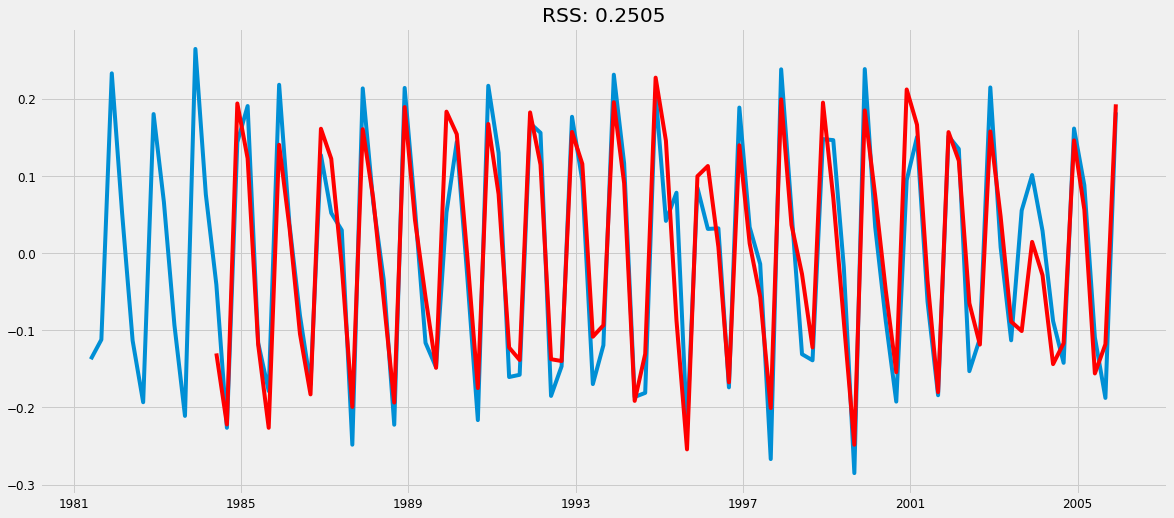

In [286]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

**Mencoba dengan Prediksi Nilai**

In [158]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Time
1984-06-01   -0.129874
1984-09-01   -0.222020
1984-12-01    0.194228
1985-03-01    0.122969
1985-06-01   -0.118490
dtype: float64


In [159]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Time
1984-06-01   -0.129874
1984-09-01   -0.351894
1984-12-01   -0.157666
1985-03-01   -0.034697
1985-06-01   -0.153187
dtype: float64


In [288]:
predictions_ARIMA_log = pd.Series(ts_log.Sales.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

1981-03-01    6.927754
1981-06-01    6.927754
1981-09-01    6.927754
1981-12-01    6.927754
1982-03-01    6.927754
dtype: float64

**Reverse Log Transform**

In [161]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5,1,'RMSE: 145.8228')

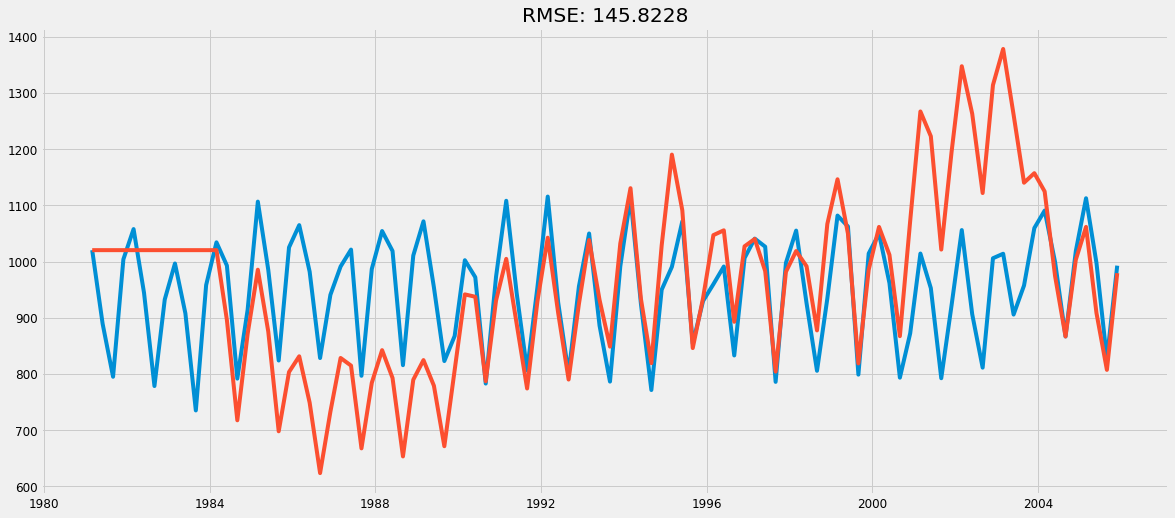

In [162]:
plt.plot(y.Sales)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.Sales)**2)/len(y.Sales)))

### MA

In [163]:
# fit model
model = ARMA(ts_log_diff, order=(0, 1))
model_fit = model.fit(disp=False)

In [164]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   99
Model:                     ARMA(0, 1)   Log Likelihood                  79.368
Method:                       css-mle   S.D. of innovations              0.106
Date:                Thu, 05 Sep 2019   AIC                           -152.736
Time:                        14:28:51   BIC                           -144.950
Sample:                    06-01-1981   HQIC                          -149.586
                         - 12-01-2005                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0003      0.000      0.838      0.404      -0.000       0.001
ma.L1.Sales    -1.0000      0.026    -38.394      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5,1,'RSS: 1.1765')

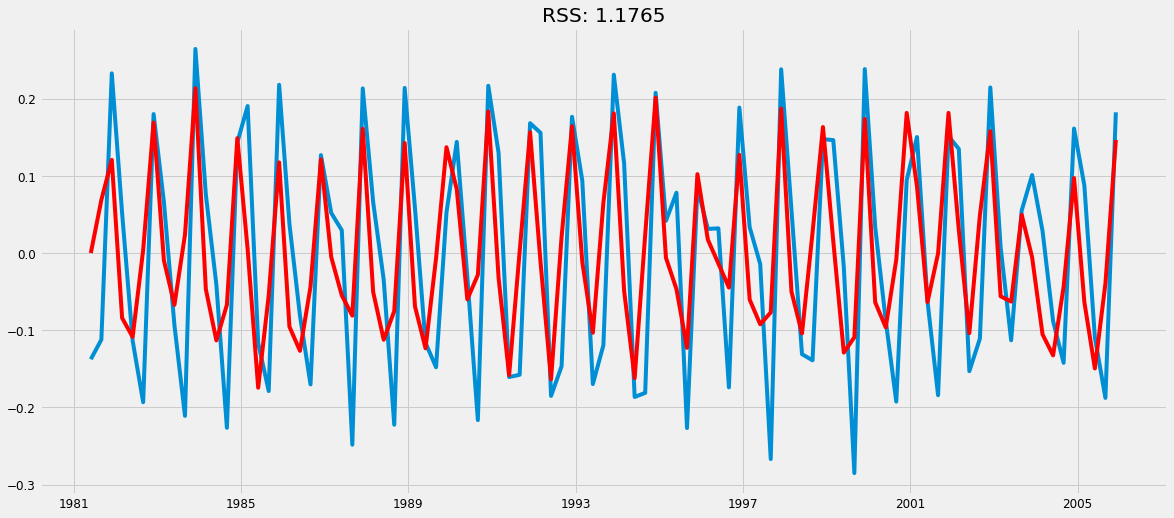

In [165]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## ARMA

In [167]:
# fit model
model = ARMA(ts_log_diff, order=(2, 1))
model_fit = model.fit(disp=True)

In [168]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   99
Model:                     ARMA(2, 1)   Log Likelihood                 112.712
Method:                       css-mle   S.D. of innovations              0.076
Date:                Thu, 05 Sep 2019   AIC                           -215.423
Time:                        14:30:46   BIC                           -202.448
Sample:                    06-01-1981   HQIC                          -210.174
                         - 12-01-2005                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0006      0.001      1.017      0.312      -0.001       0.002
ar.L1.Sales    -0.0496      0.074     -0.670      0.504      -0.195       0.095
ar.L2.Sales    -0.7304      0.073    -10.000      0.000      -0.874      -0.587
ma.L1.Sales    -0.8802      0.106     -8.341      0.000      -1.087      -0.673
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.0340           -1.1696j            1.1701           -0.2546
AR.2           -0.0340           +1.1696j            1.1701            0.2546
MA.1            1.1361           +0.0000j            1.1361            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5,1,'RSS: 0.6060')

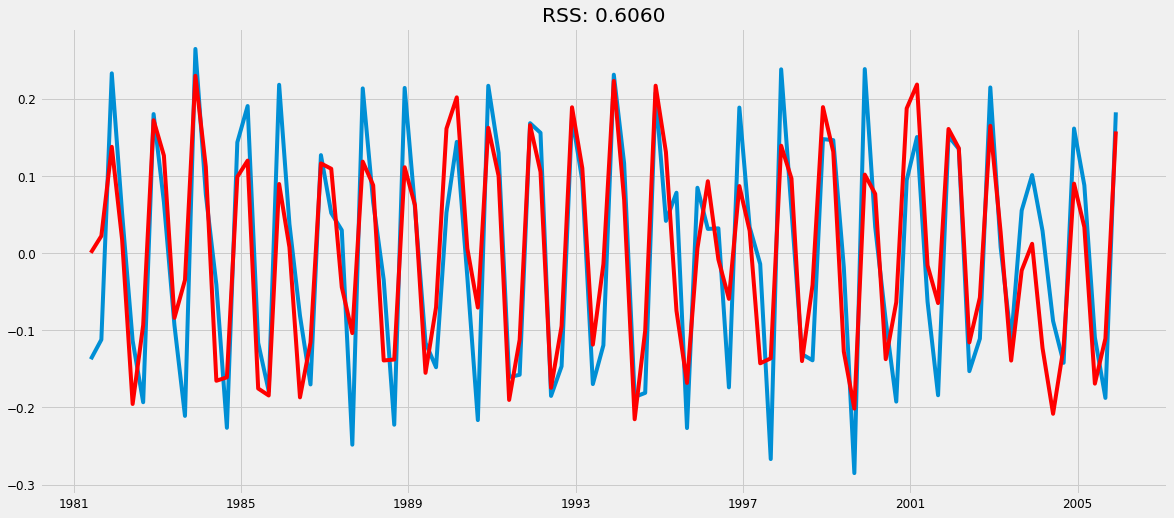

In [169]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## ARIMA

In [170]:
ts = y.Sales - y.Sales.shift()
ts.dropna(inplace=True)

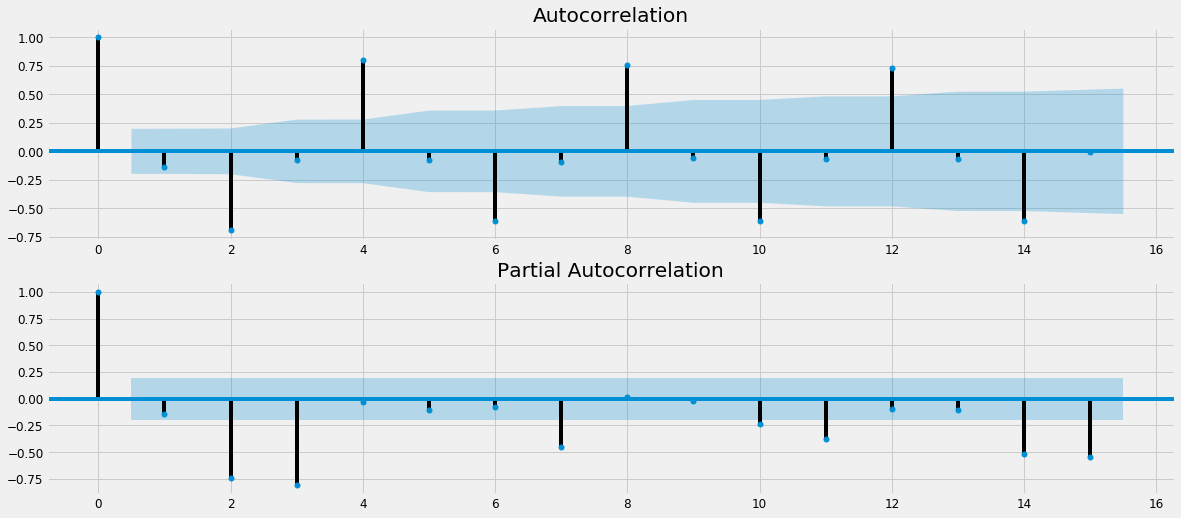

In [172]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=15)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=15)
pyplot.show()

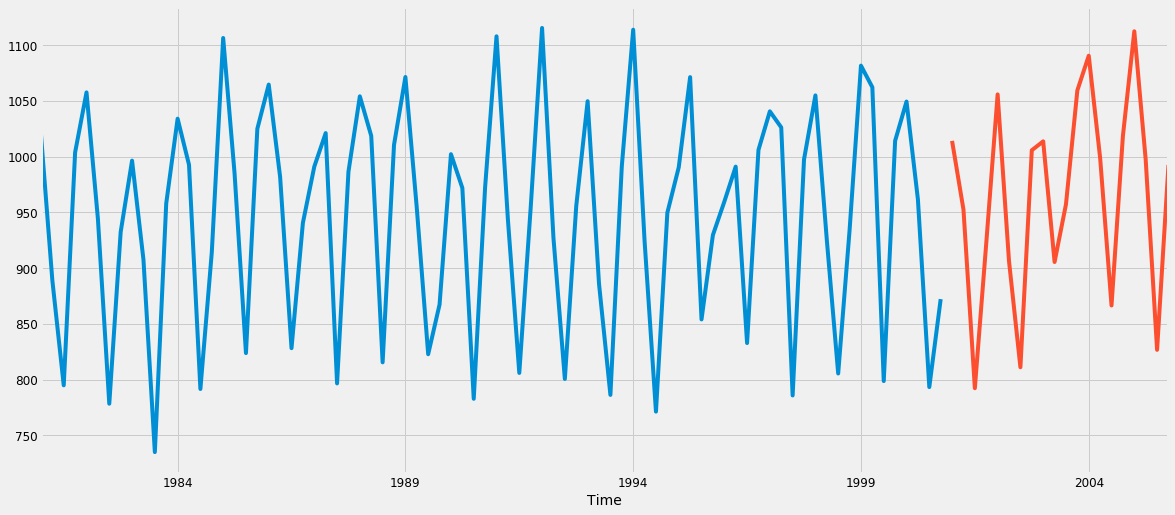

In [314]:
#divide into train and validation set
train = y[:int(0.80*(len(y)))]
valid = y[int(0.80*(len(y))):]

#plotting the data
train['Sales'].plot()
valid['Sales'].plot()

In [324]:
# fit model
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit(disp=1)

In [325]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                   79
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -478.103
Method:                       css-mle   S.D. of innovations            100.006
Date:                Thu, 05 Sep 2019   AIC                            964.206
Time:                        16:48:17   BIC                            973.684
Sample:                    06-01-1981   HQIC                           968.004
                         - 12-01-2000                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1192      0.483      0.247      0.806      -0.827       1.066
ar.L1.D.Sales    -0.0031      0.113     -0.027      0.978      -0.225       0.219
ma.L1.D.Sales    -1.0000      0.032    -30.967      0.000      -1.063      -0.937
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1         -321.8129           +0.0000j          321.8129            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [326]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [327]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 965.0835084766134, MSE:931386.1783335295


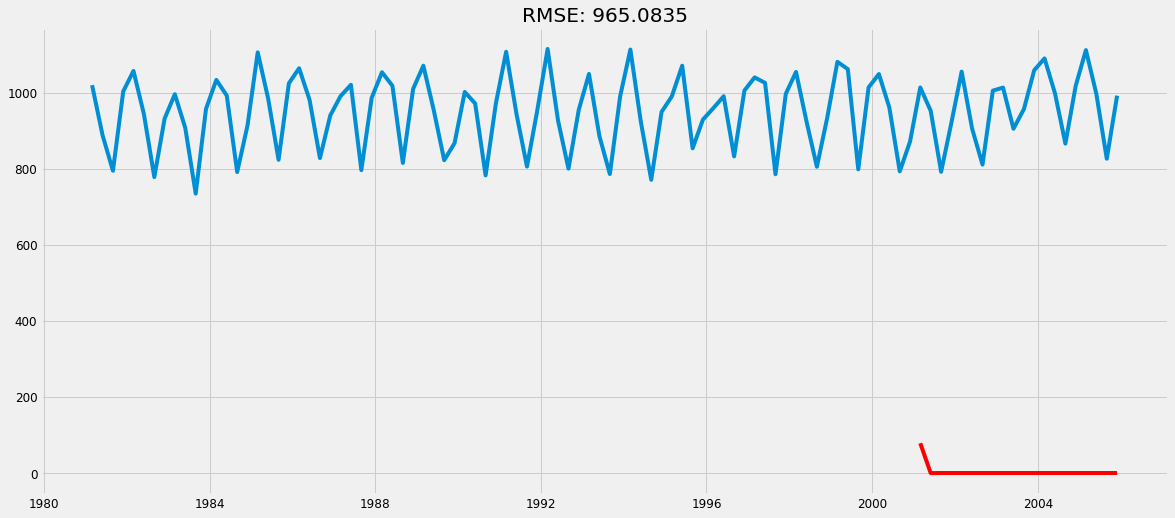

In [328]:
plt.plot(y.Sales)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

**fitted training value**

In [330]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

2001-03-01    78.410558
2001-06-01    -0.124037
2001-09-01     0.120001
2001-12-01     0.119243
2002-03-01     0.119245
Freq: QS-DEC, dtype: float64


In [331]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

2001-03-01    78.410558
2001-06-01    78.286521
2001-09-01    78.406522
2001-12-01    78.525765
2002-03-01    78.645010
Freq: QS-DEC, dtype: float64


In [332]:
predictions_ARIMA_log = pd.Series(valid.Sales.iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Time
2001-03-01    1092.610558
2001-06-01    1092.486521
2001-09-01    1092.606522
2001-12-01    1092.725765
2002-03-01    1092.845010
dtype: float64

Text(0.5,1,'RMSE: 491.9510')

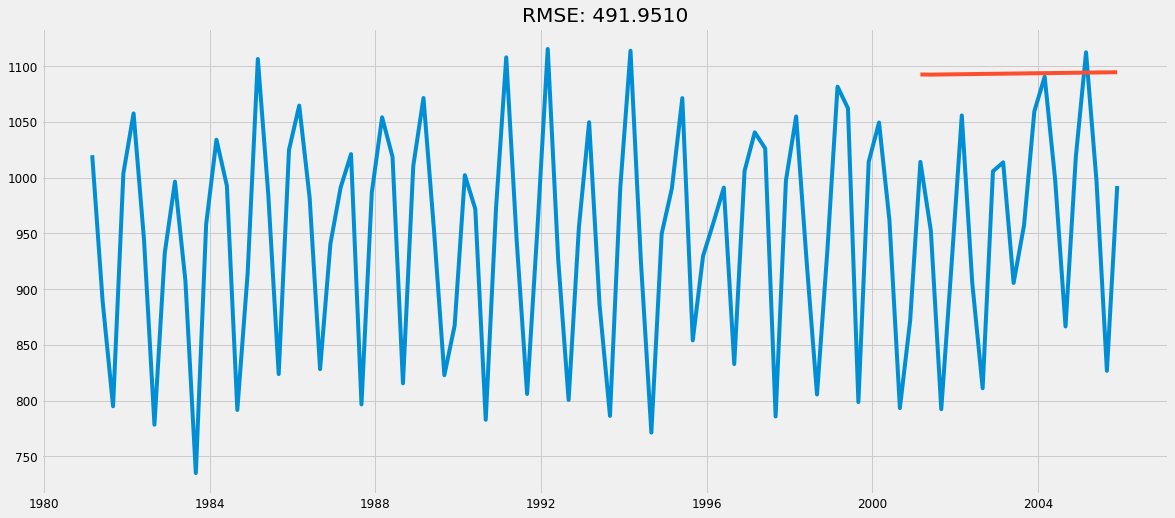

In [333]:
plt.plot(y.Sales)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))

## Auto ARIMA

In [334]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=867.848, BIC=882.140, Fit time=0.425 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=966.928, BIC=971.692, Fit time=0.000 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=968.913, BIC=976.059, Fit time=0.047 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=967.466, BIC=974.612, Fit time=0.047 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=943.454, BIC=955.364, Fit time=0.234 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=868.014, BIC=884.688, Fit time=0.359 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=934.132, BIC=946.042, Fit time=0.311 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=866.471, BIC=883.145, Fit time=0.387 seconds
Fit ARIMA: order=(3, 0, 4) seasonal_order=(0, 0, 0, 1); AIC=871.446, BIC=892.884, Fit time=0.499 seconds
Fit ARIMA: order=(1, 0, 3) seasonal_order=(0, 0, 0, 1);

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 0, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

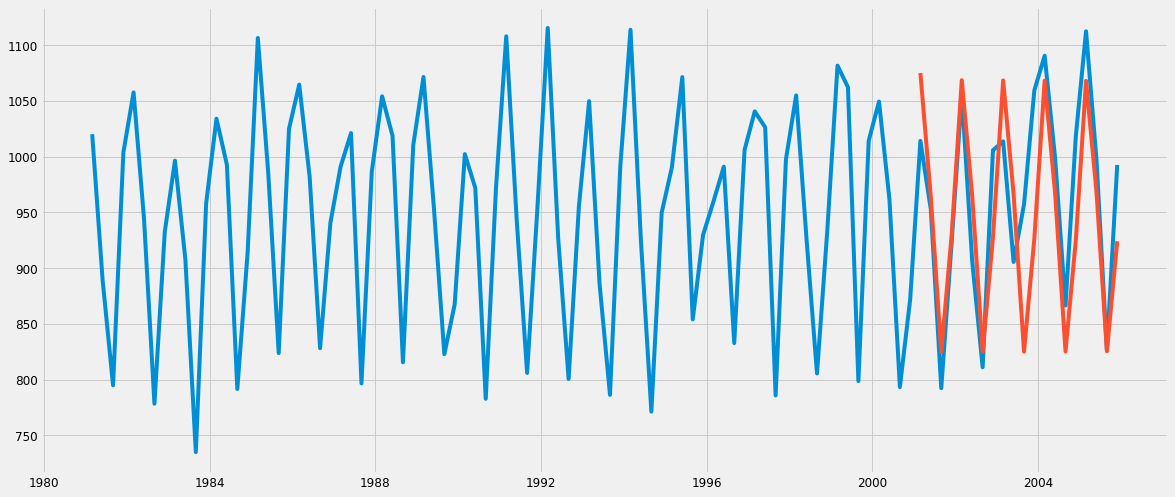

In [335]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.Sales, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [338]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Nilai MAPE ARIMA(4,0,5)

In [339]:
mean_absolute_percentage_error(y.Sales, predictions_ARIMA)

11.588587315126428

In [342]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [343]:
evaluate_forecast(valid, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.519964,49.299887,42.84584,3799.121999,0.004179,NaN,61.637018


### SARIMA

In [344]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [345]:
min_aic = 9999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1309.3393395564117
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1150.7489402446342
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:970.8201430388475
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:816.9323614376062
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:985.8642284862096
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:900.42249682414
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:755.748954053699
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:747.4732034644364
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1207.3394046902822
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:1065.3870416786185
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:935.6665220050359
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:797.8097439255719
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:970.9601104178357
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:883.5741305725494
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:757.7228411995602
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:736.9395190970744
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:996.589244688922
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:907.7079594116741
ARIMA(0, 1, 0)x(0, 1, 0, 6)1

In [258]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                   75
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -330.425
Date:                           Thu, 05 Sep 2019   AIC                            668.850
Time:                                   15:22:33   BIC                            677.227
Sample:                               03-01-1981   HQIC                           672.127
                                    - 09-01-1999                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000    614.208     -0.002      0.999   -1204.826    1202.826
ar.S.L6       -0.9876      0.011    -93.179      0.000      -1.008      -0.967
ma.S.L6        1.0000    614.228      0.002      0.999   -1202.864    1204.864
sigma2      2775.3525      0.187   1.48e+04      0.000    2774.986    2775.719
===================================================================================
Ljung-Box (Q):                       48.52   Jarque-Bera (JB):                 2.36
Prob(Q):                              0.17   Prob(JB):                         0.31
Heteroskedasticity (H):               1.49   Skew:                            -0.05
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.16e+24. Standard errors may be unstable.
"""

In [259]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

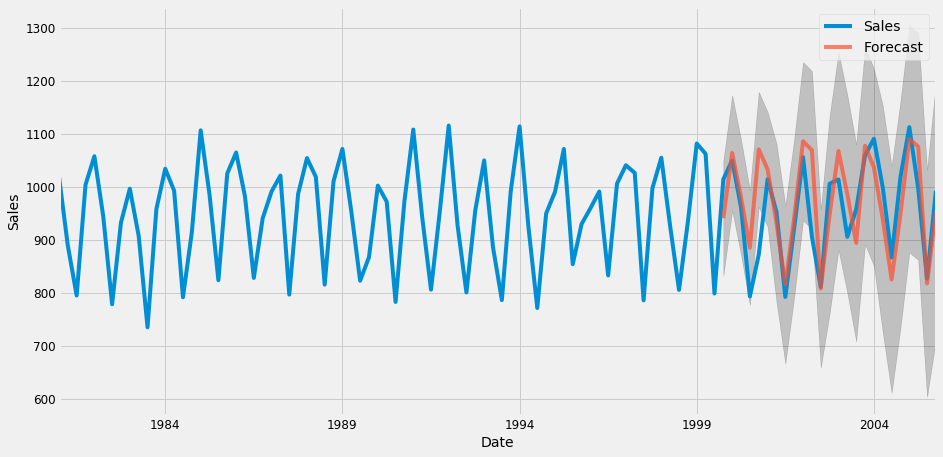

In [260]:
pred_ci = pred.conf_int()
ax = y['1970':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

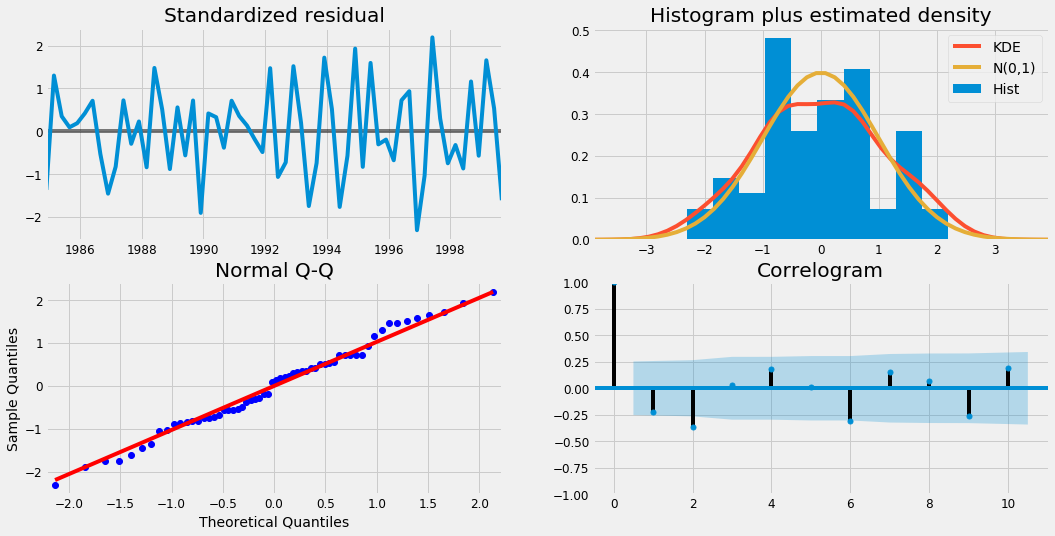

In [261]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [265]:
evaluate_forecast(y_truth, y_forecasted)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-0.113003,80.621499,70.69256,9135.525231,0.010346,8.583748,95.579942


,Sales
Time,
1981-03-01,1020.2
1981-06-01,889.2
1981-09-01,795.0
1981-12-01,1003.9
1982-03-01,1057.7
